# Analysis of running performance as a function of sex and neuter status of the opposite running dog

## Data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import f_oneway, tukey_hsd

pd.set_option('display.max_columns', None)

/tmp/ipykernel_9848/1605441955.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('races.csv')
df = df[df.team1.str.startswith('Wild')]
df = df.dropna(subset=['course_color'])

df['time1'] = df['time1'].apply(lambda x: float(x) if x.replace('.','',1).isdigit() else x)
df['time2'] = df['time2'].apply(lambda x: float(x) if x.replace('.','',1).isdigit() else x)
df['time3'] = df['time3'].apply(lambda x: float(x) if x.replace('.','',1).isdigit() else x)
df['time4'] = df['time4'].apply(lambda x: float(x) if x.replace('.','',1).isdigit() else x)

print(df.shape)
df.head(2)

(1055, 21)


,division,when,team1,team2,time_tot,win,hurdles,name1,start_chng1,time1,name2,start_chng2,time2,name3,start_chng3,time3,name4,start_chng4,time4,event,course_color
0,1,2023-04-22 10:11:57,WildRunners dreamers,WildRunners Maximini,17.01,L,25.0,Sunny,-0.24,4.21,Dixie,0.30,4.24,Alex,0.16,4.22,Hector,0.0,4.13,Hanácké škvarek (Heroltice),blue
1,1,2023-04-22 10:11:57,WildRunners Maximini,WildRunners dreamers,19.43,L,25.0,Brooke,-0.11,4.08,Rocky,1.29,5.15,Bella,0.23,4.52,Bree,0.0,4.28,Hanácké škvarek (Heroltice),red


In [3]:
df_dogs = pd.read_csv('dogs.csv')
df_dogs.head()

,trainer,name,breed,sex,neutered,birth,ulna_length,jump_height
0,TM800418,Dexter,Kooikerhondje,M,Y,2010-02-14,14.05,25.0
1,NP950613,Jasper,Border Collie,M,Y,2011-03-28,16.56,30.0
2,UF830429,Angie,Border Collie,F,Y,2014-02-06,15.22,27.5
3,ZE801127,Alex,Border Collie,M,Y,2014-04-22,17.95,32.5
4,DP910919,Ashley,Border Collie,F,Y,2015-01-26,18.30,32.5


In [4]:
df_run1 = df[['team1', 'name1', 'name2', 'time2']]
df_run2 = df[['team1', 'name2', 'name3', 'time3']]
df_run3 = df[['team1', 'name3', 'name4', 'time4']]

col_names = ['team', 'prev_dog', 'curr_dog', 'time']
df_run1.columns = col_names
df_run2.columns = col_names
df_run3.columns = col_names

df_runs = pd.concat([df_run1, df_run2, df_run3])
df_runs = df_runs.dropna(subset=['time'])

df_runs = df_runs.merge(df_dogs, left_on='prev_dog', right_on='name')[['team', 'prev_dog', 'curr_dog', 'time', 'sex', 'neutered']]
df_runs.columns = ['team', 'prev_dog', 'curr_dog', 'time', 'prev_sex', 'prev_neutered']

df_runs = df_runs.merge(df_dogs, left_on='curr_dog', right_on='name')[['team', 'prev_dog', 'curr_dog', 'time', 'prev_sex', 'prev_neutered', 'sex', 'neutered']]
df_runs.columns = ['team', 'prev_dog', 'curr_dog', 'time', 'prev_sex', 'prev_neutered', 'curr_sex', 'curr_neutered']

df_runs['time'] = pd.to_numeric(df_runs['time'], errors='coerce')
df_runs = df_runs.dropna(subset=['time'])
df_runs = df_runs[df_runs.time < 8]

print(df_runs.shape)
df_runs.head(5)

(3088, 8)


,team,prev_dog,curr_dog,time,prev_sex,prev_neutered,curr_sex,curr_neutered
0,WildRunners dreamers,Sunny,Dixie,4.24,F,Y,M,Y
1,WildRunners Maximini,Brooke,Rocky,5.15,M,N,M,Y
2,WildRunners dreamers,Sunny,Dixie,4.23,F,Y,M,Y
3,WildRunners Maximini,Brooke,Rocky,5.50,M,N,M,Y
4,WildRunners dreamers,Sunny,Dixie,4.29,F,Y,M,Y


<Axes: >

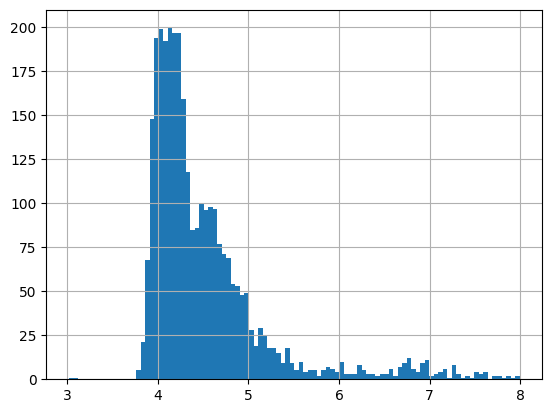

In [5]:
df_runs.time.hist(bins=100)

In [6]:
def myplot(df):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    df.groupby(['prev_sex', 'prev_neutered'])['time'].mean().plot(kind='barh', xerr=df.groupby(['prev_sex', 'prev_neutered'])['time'].std(), ax=axs[0])
    axs[0].set_xlabel('Average Running Time [s]')
    axs[0].set_ylabel('Sex (M/F) and neutered status (Y/N) of the lead dog')

    g1 = df[(df_runs.prev_sex == 'M') & (df.prev_neutered == 'Y')]['time']
    g2 = df[(df_runs.prev_sex == 'M') & (df.prev_neutered == 'N')]['time']
    g3 = df[(df_runs.prev_sex == 'F') & (df.prev_neutered == 'Y')]['time']
    g4 = df[(df_runs.prev_sex == 'F') & (df.prev_neutered == 'N')]['time']

    data = [g1, g2, g3, g4]
    _, p_value = f_oneway(*data)

    tukey_results = tukey_hsd(*data)
    p_values = tukey_results.pvalue
    p_values_2d = np.array(p_values).reshape(4, 4)

    labels = ['M-Y', 'M-N', 'F-Y', 'F-N']
    sns.heatmap(p_values_2d, annot=True, cmap='inferno', fmt='.3f', xticklabels=labels, yticklabels=labels, ax=axs[1])
    plt.title('Tukey\'s HSD Pairwise Group Comparisons (p-values)')
    plt.show()

    print("ANOVA overall p-value:", p_value)
    print('Size of the four groups:', g1.shape[0], g2.shape[0], g3.shape[0], g4.shape[0])
    print(tukey_results)


Interesting. Seems that dogs run faster in avereage, if running against a non-neutered female dog. Let's perform an ANOVA test to check if this difference is significant. 

Very little p-value indicates, that indeed, there is a significant difference of at least one of the four groups

By checking the results between each pair it turns out:
- The differences are significant between each pair of groups
- Largest difference is between non-neutered male and non-neutered female dogs (as changing partners or previous dogs). 95% confindence interwall is 0.4 to 0.7 seconds.

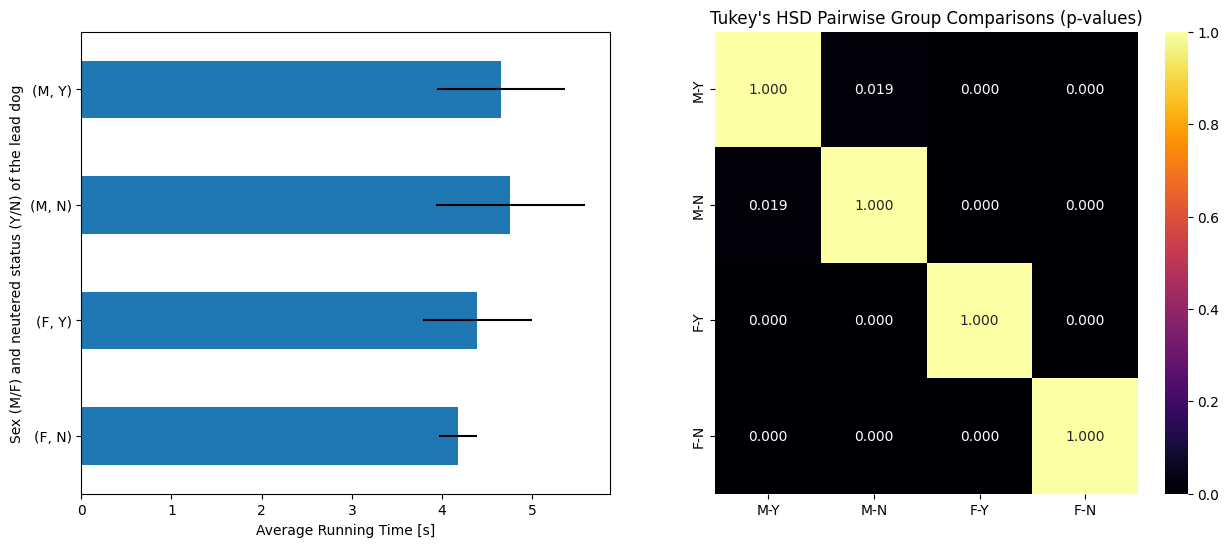

ANOVA overall p-value: 8.165288104544294e-43
Size of the four groups: 1098 472 1307 211
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.106     0.019    -0.200    -0.013
 (0 - 2)      0.257     0.000     0.187     0.326
 (0 - 3)      0.469     0.000     0.341     0.597
 (1 - 0)      0.106     0.019     0.013     0.200
 (1 - 2)      0.363     0.000     0.271     0.454
 (1 - 3)      0.575     0.000     0.434     0.716
 (2 - 0)     -0.257     0.000    -0.326    -0.187
 (2 - 1)     -0.363     0.000    -0.454    -0.271
 (2 - 3)      0.213     0.000     0.086     0.339
 (3 - 0)     -0.469     0.000    -0.597    -0.341
 (3 - 1)     -0.575     0.000    -0.716    -0.434
 (3 - 2)     -0.213     0.000    -0.339    -0.086



In [7]:
myplot(df_runs)

OK, now as we know that changing agist female dogs, especially against non-neutered female dogs provide a significantly better running performance globally, let's check the 4 gorups one by one. I am going to use the following notation:

- Female neutered: FY
- Female non-neutered: FN
- Male neutered: MY
- Male non-neutered: MN



## All males

In [8]:
df_M = df_runs[(df_runs.curr_sex == 'M')]
df_M.shape

(1541, 8)

/tmp/ipykernel_9848/2239366154.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g1 = df[(df_runs.prev_sex == 'M') & (df.prev_neutered == 'Y')]['time']
/tmp/ipykernel_9848/2239366154.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g2 = df[(df_runs.prev_sex == 'M') & (df.prev_neutered == 'N')]['time']
/tmp/ipykernel_9848/2239366154.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g3 = df[(df_runs.prev_sex == 'F') & (df.prev_neutered == 'Y')]['time']
/tmp/ipykernel_9848/2239366154.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g4 = df[(df_runs.prev_sex == 'F') & (df.prev_neutered == 'N')]['time']


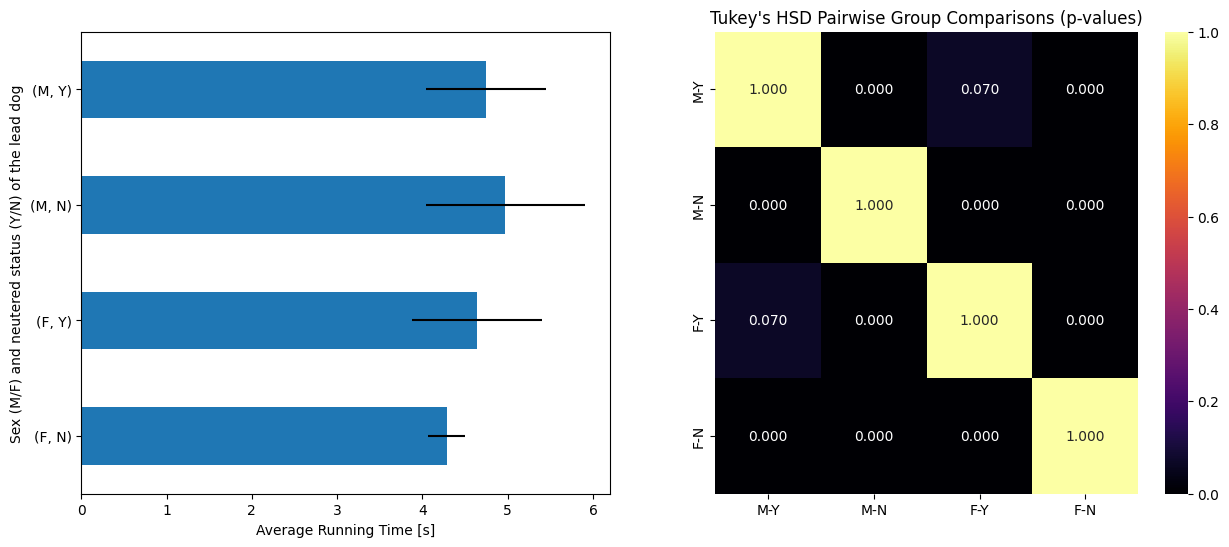

ANOVA overall p-value: 5.865379808619396e-16
Size of the four groups: 626 273 532 110
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.226     0.000    -0.366    -0.087
 (0 - 2)      0.107     0.070    -0.006     0.221
 (0 - 3)      0.462     0.000     0.264     0.661
 (1 - 0)      0.226     0.000     0.087     0.366
 (1 - 2)      0.334     0.000     0.191     0.477
 (1 - 3)      0.689     0.000     0.472     0.906
 (2 - 0)     -0.107     0.070    -0.221     0.006
 (2 - 1)     -0.334     0.000    -0.477    -0.191
 (2 - 3)      0.355     0.000     0.154     0.556
 (3 - 0)     -0.462     0.000    -0.661    -0.264
 (3 - 1)     -0.689     0.000    -0.906    -0.472
 (3 - 2)     -0.355     0.000    -0.556    -0.154



In [9]:
myplot(df_M)

## Male non-neutered: MN

Overall p-value of 0.18 indicates the lack of significance in case of non-neutered male dogs. Meaning, that if the current dog is a non-neutered male, then it does not matter which group the previous, opposite running dog is belonging to.

In [8]:
df_MN = df_runs[(df_runs.curr_sex == 'M') & (df_runs.curr_neutered == 'N')]
df_MN.shape

(449, 8)

/tmp/ipykernel_10909/2239366154.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g1 = df[(df_runs.prev_sex == 'M') & (df.prev_neutered == 'Y')]['time']
/tmp/ipykernel_10909/2239366154.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g2 = df[(df_runs.prev_sex == 'M') & (df.prev_neutered == 'N')]['time']
/tmp/ipykernel_10909/2239366154.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g3 = df[(df_runs.prev_sex == 'F') & (df.prev_neutered == 'Y')]['time']
/tmp/ipykernel_10909/2239366154.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g4 = df[(df_runs.prev_sex == 'F') & (df.prev_neutered == 'N')]['time']


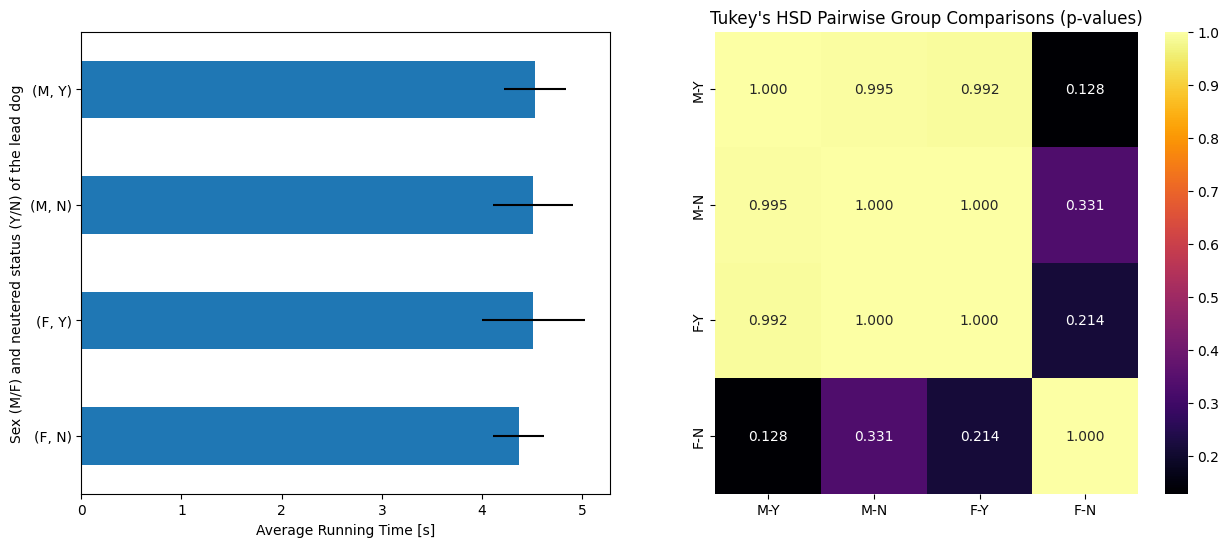

ANOVA overall p-value: 0.18704030941444125
Size of the four groups: 236 54 128 31
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.014     0.995    -0.135     0.164
 (0 - 2)      0.012     0.992    -0.097     0.121
 (0 - 3)      0.161     0.128    -0.029     0.351
 (1 - 0)     -0.014     0.995    -0.164     0.135
 (1 - 2)     -0.003     1.000    -0.164     0.158
 (1 - 3)      0.146     0.331    -0.077     0.370
 (2 - 0)     -0.012     0.992    -0.121     0.097
 (2 - 1)      0.003     1.000    -0.158     0.164
 (2 - 3)      0.149     0.214    -0.049     0.348
 (3 - 0)     -0.161     0.128    -0.351     0.029
 (3 - 1)     -0.146     0.331    -0.370     0.077
 (3 - 2)     -0.149     0.214    -0.348     0.049



In [9]:
myplot(df_MN)

## Male neutered: MY

The results for neutered male dogs is similar to the overall results:
- The difference is significant between each pair of groups
- Running aginast females is better than running agains males
- Best performance occurs when running agains a non-neutered female

In [10]:
df_MY = df_runs[(df_runs.curr_sex == 'M') & (df_runs.curr_neutered == 'Y')]
df_MY.shape

(1092, 8)

/tmp/ipykernel_10909/2239366154.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g1 = df[(df_runs.prev_sex == 'M') & (df.prev_neutered == 'Y')]['time']
/tmp/ipykernel_10909/2239366154.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g2 = df[(df_runs.prev_sex == 'M') & (df.prev_neutered == 'N')]['time']
/tmp/ipykernel_10909/2239366154.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g3 = df[(df_runs.prev_sex == 'F') & (df.prev_neutered == 'Y')]['time']
/tmp/ipykernel_10909/2239366154.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g4 = df[(df_runs.prev_sex == 'F') & (df.prev_neutered == 'N')]['time']


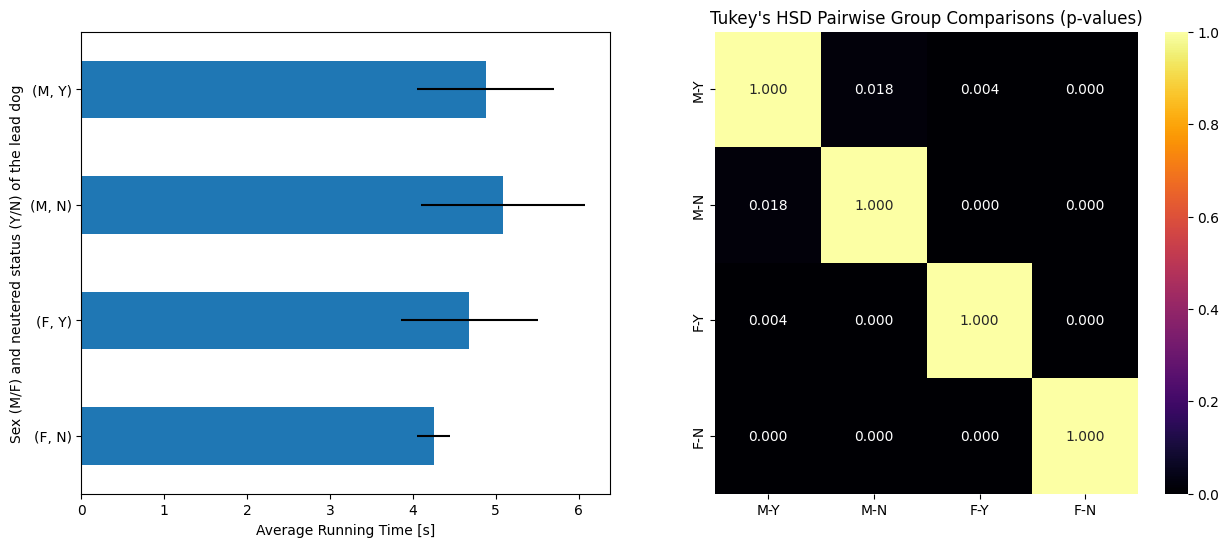

ANOVA overall p-value: 4.276260870336444e-15
Size of the four groups: 390 219 404 79
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.206     0.018    -0.387    -0.025
 (0 - 2)      0.202     0.004     0.050     0.354
 (0 - 3)      0.628     0.000     0.364     0.892
 (1 - 0)      0.206     0.018     0.025     0.387
 (1 - 2)      0.408     0.000     0.228     0.588
 (1 - 3)      0.834     0.000     0.553     1.115
 (2 - 0)     -0.202     0.004    -0.354    -0.050
 (2 - 1)     -0.408     0.000    -0.588    -0.228
 (2 - 3)      0.426     0.000     0.162     0.690
 (3 - 0)     -0.628     0.000    -0.892    -0.364
 (3 - 1)     -0.834     0.000    -1.115    -0.553
 (3 - 2)     -0.426     0.000    -0.690    -0.162



In [11]:
myplot(df_MY)

## All females

In [10]:
df_F = df_runs[(df_runs.curr_sex == 'F')]
df_F.shape

(1547, 8)

/tmp/ipykernel_9848/2239366154.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g1 = df[(df_runs.prev_sex == 'M') & (df.prev_neutered == 'Y')]['time']
/tmp/ipykernel_9848/2239366154.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g2 = df[(df_runs.prev_sex == 'M') & (df.prev_neutered == 'N')]['time']
/tmp/ipykernel_9848/2239366154.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g3 = df[(df_runs.prev_sex == 'F') & (df.prev_neutered == 'Y')]['time']
/tmp/ipykernel_9848/2239366154.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g4 = df[(df_runs.prev_sex == 'F') & (df.prev_neutered == 'N')]['time']


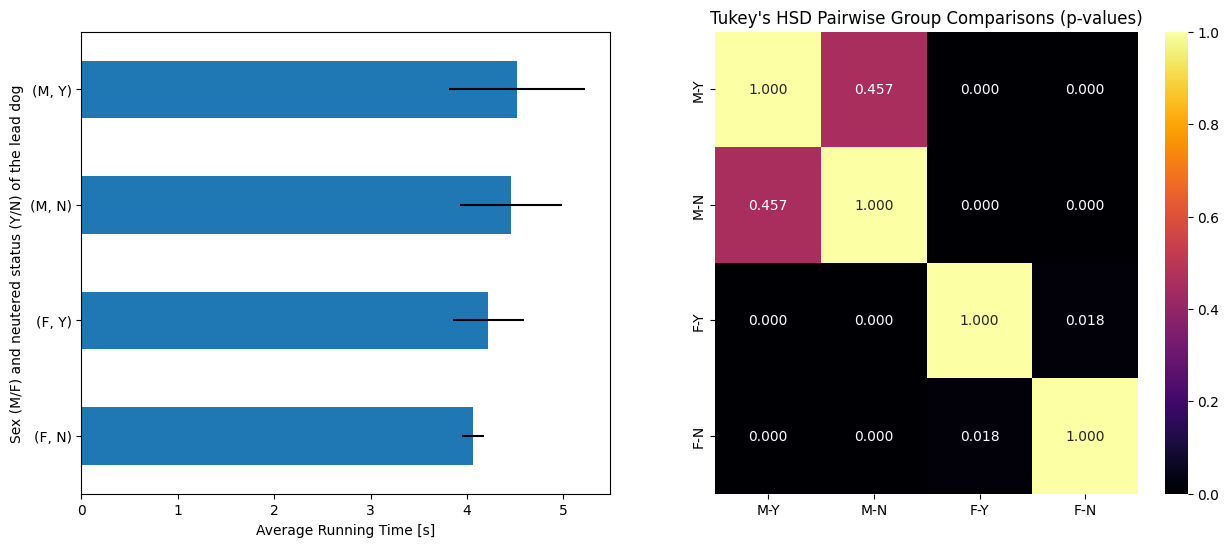

ANOVA overall p-value: 5.0082250826104393e-29
Size of the four groups: 472 199 775 101
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.063     0.457    -0.047     0.173
 (0 - 2)      0.296     0.000     0.220     0.372
 (0 - 3)      0.453     0.000     0.311     0.595
 (1 - 0)     -0.063     0.457    -0.173     0.047
 (1 - 2)      0.233     0.000     0.130     0.337
 (1 - 3)      0.390     0.000     0.232     0.549
 (2 - 0)     -0.296     0.000    -0.372    -0.220
 (2 - 1)     -0.233     0.000    -0.337    -0.130
 (2 - 3)      0.157     0.018     0.020     0.294
 (3 - 0)     -0.453     0.000    -0.595    -0.311
 (3 - 1)     -0.390     0.000    -0.549    -0.232
 (3 - 2)     -0.157     0.018    -0.294    -0.020



In [11]:
myplot(df_F)

## Female non-neutered: FN

Even in case of non-neutered females, the result is better if they run against a female dog.

This goup is however the smallest one, and there is no single example in our dataset when an FN is running agains another FN dog.

In [12]:
df_FN = df_runs[(df_runs.curr_sex == 'F') & (df_runs.curr_neutered == 'N')]
df_FN.shape

(213, 8)

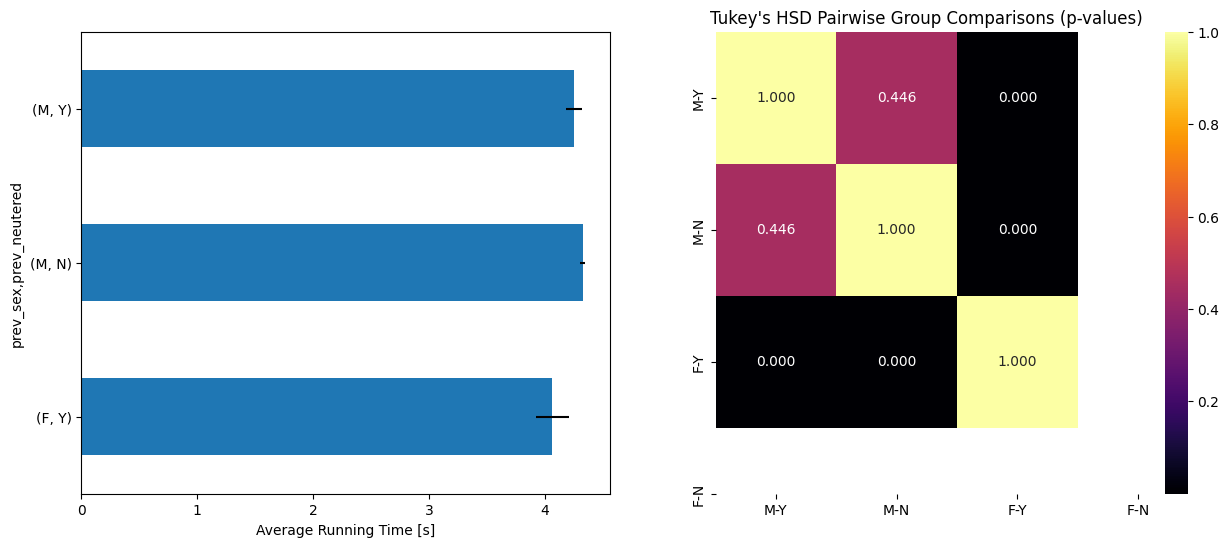

ANOVA overall p-value: 9.117778584908817e-13
Size of the four groups: 25 6 182
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.073     0.446    -0.213     0.068
 (0 - 2)      0.187     0.000     0.121     0.253
 (1 - 0)      0.073     0.446    -0.068     0.213
 (1 - 2)      0.259     0.000     0.131     0.388
 (2 - 0)     -0.187     0.000    -0.253    -0.121
 (2 - 1)     -0.259     0.000    -0.388    -0.131



In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

df_FN.groupby(['prev_sex', 'prev_neutered'])['time'].mean().plot(kind='barh', xerr=df_FN.groupby(['prev_sex', 'prev_neutered'])['time'].std(), ax=axs[0])
axs[0].set_xlabel('Average Running Time [s]')

g1 = df_FN[(df_FN.prev_sex == 'M') & (df_FN.prev_neutered == 'Y')]['time']
g2 = df_FN[(df_FN.prev_sex == 'M') & (df_FN.prev_neutered == 'N')]['time']
g3 = df_FN[(df_FN.prev_sex == 'F') & (df_FN.prev_neutered == 'Y')]['time']
#g4 = df_FN[(df_FN.prev_sex == 'F') & (df_FN.prev_neutered == 'N')]['time']

data = [g1, g2, g3]
_, p_value = f_oneway(*data)

tukey_results = tukey_hsd(*data)
p_values = tukey_results.pvalue
p_values_2d = np.array(p_values).reshape(3,3)

labels = ['M-Y', 'M-N', 'F-Y', 'F-N']
sns.heatmap(p_values_2d, annot=True, cmap='inferno', fmt='.3f', xticklabels=labels, yticklabels=labels, ax=axs[1])
plt.title('Tukey\'s HSD Pairwise Group Comparisons (p-values)')
plt.show()

print("ANOVA overall p-value:", p_value)
print('Size of the four groups:', g1.shape[0], g2.shape[0], g3.shape[0])
print(tukey_results)

## Female neutered: FY

Similar results as above. The running perfomrance is better when running against a female, especially against a non-neutered female

In [14]:
df_FY = df_runs[(df_runs.curr_sex == 'F') & (df_runs.curr_neutered == 'Y')]
df_FY.shape

(1334, 8)

/tmp/ipykernel_10909/2239366154.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g1 = df[(df_runs.prev_sex == 'M') & (df.prev_neutered == 'Y')]['time']
/tmp/ipykernel_10909/2239366154.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g2 = df[(df_runs.prev_sex == 'M') & (df.prev_neutered == 'N')]['time']
/tmp/ipykernel_10909/2239366154.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g3 = df[(df_runs.prev_sex == 'F') & (df.prev_neutered == 'Y')]['time']
/tmp/ipykernel_10909/2239366154.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g4 = df[(df_runs.prev_sex == 'F') & (df.prev_neutered == 'N')]['time']


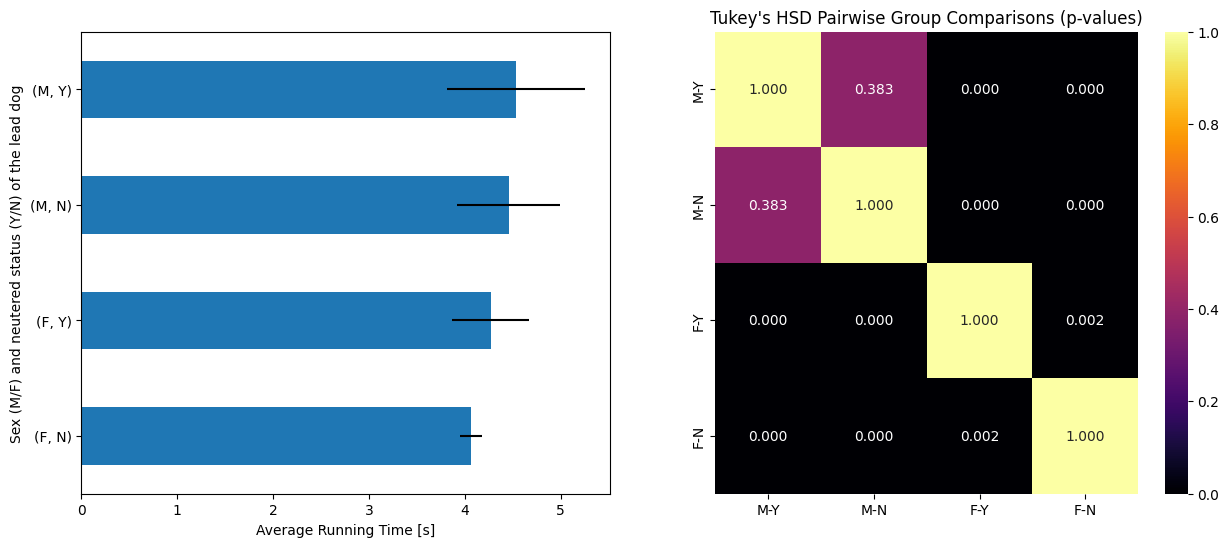

ANOVA overall p-value: 9.995738549212112e-21
Size of the four groups: 447 193 593 101
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.074     0.383    -0.045     0.192
 (0 - 2)      0.262     0.000     0.176     0.349
 (0 - 3)      0.468     0.000     0.316     0.620
 (1 - 0)     -0.074     0.383    -0.192     0.045
 (1 - 2)      0.189     0.000     0.075     0.303
 (1 - 3)      0.394     0.000     0.225     0.564
 (2 - 0)     -0.262     0.000    -0.349    -0.176
 (2 - 1)     -0.189     0.000    -0.303    -0.075
 (2 - 3)      0.206     0.002     0.057     0.354
 (3 - 0)     -0.468     0.000    -0.620    -0.316
 (3 - 1)     -0.394     0.000    -0.564    -0.225
 (3 - 2)     -0.206     0.002    -0.354    -0.057



In [15]:
myplot(df_FY)

## Conclusion

- Generally speaking, running performance is singificantly better when a dog is running opposite to a female, especially to a non-neutered female.
- This seems to be generally true for neutered dogs, both males and females
- I found no significant difference in the group of non-neutered males. They also run somewhat faster against non-neuterd females but the difference is not significat.
- There is not enough data to draw a clear conclusion about non-neutered females, but they also run faster against females.
